<a href="https://colab.research.google.com/github/itsfloppyhat/Proj5/blob/main/Proj5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import files

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk, re, string

Add data and ensure it is available

In [ ]:
df = pd.read_csv("bike_rental_reviews.csv")

for pkg in ["stopwords", "wordnet"]:
    try: nltk.data.find(f"corpora/{pkg}")
    except LookupError: nltk.download(pkg)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Clean Text

In [ ]:
sw = set(stopwords.words('english'))
lemm = WordNetLemmatizer()
punct_table = str.maketrans('', '', string.punctuation)

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"\d+", " ", s)
    s = s.translate(punct_table)
    toks = [w for w in s.split() if w not in sw]
    toks = [lemm.lemmatize(w) for w in toks]
    return " ".join(toks)

pick text/labels

In [ ]:
text_col = next((c for c in df.columns if c.lower() in
                 {"review","text","comment","message","content","review_text","feedback","body"}), None)
label_col = next((c for c in df.columns if c.lower() in {"sentiment","label","polarity","target"}), None)
rating_col = next((c for c in df.columns if c.lower() in {"rating","stars","score"}), None)

assert text_col is not None, "Could not find review text column."
print("Text column:", text_col)


Text column: review_text


Detect class labels positive, negative, neutral

In [ ]:
if label_col is None and rating_col is not None:
    ser = pd.to_numeric(df[rating_col], errors="coerce")
    if ser.max() <= 5:
        df["sentiment_label"] = ser.apply(lambda v: "positive" if v >= 4 else ("negative" if v <= 2 else "neutral"))
    else:
        df["sentiment_label"] = ser.apply(lambda v: "positive" if v >= 7 else ("negative" if v <= 3 else "neutral"))
    label_col = "sentiment_label"
elif label_col is not None:
    def norm_label(x):
        x = str(x).strip().lower()
        if x in {"positive","pos","5","4","good","great"}: return "positive"
        if x in {"negative","neg","bad","poor","1"}: return "negative"
        if x in {"neutral","neu","3"}: return "neutral"
        try:
            v = float(x);
            return "positive" if v>=4 else ("negative" if v<=2 else "neutral")
        except: return None
    df["sentiment_label"] = df[label_col].apply(norm_label)
    label_col = "sentiment_label"
else:
    raise ValueError("Need either a sentiment label column or a rating column.")

df["clean_text"] = df[text_col].astype(str).apply(clean_text)
df_model = df[["clean_text", label_col]].dropna().copy()

TF/IDF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# handle rare classes
min_per_class = 5
keep = df_model[label_col].value_counts()
keep = keep[keep >= min_per_class].index
df_model = df_model[df_model[label_col].isin(keep)].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df_model["clean_text"], df_model[label_col],
    test_size=0.2, stratify=df_model[label_col], random_state=42
)

tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), min_df=2, sublinear_tf=True)
Xtr = tfidf.fit_transform(X_train); Xte = tfidf.transform(X_test)

# NB
nb = MultinomialNB().fit(Xtr, y_train)
nb_pred = nb.predict(Xte)
print("NB acc:", accuracy_score(y_test, nb_pred), "macroF1:", f1_score(y_test, nb_pred, average="macro"))
print(classification_report(y_test, nb_pred, zero_division=0))

# LR (accuracy-first)
lr = LogisticRegression(max_iter=4000, C=2.0, class_weight="balanced", solver="liblinear", multi_class="ovr").fit(Xtr, y_train)
lr_pred = lr.predict(Xte)
print("LR acc:", accuracy_score(y_test, lr_pred), "macroF1:", f1_score(y_test, lr_pred, average="macro"))
print(classification_report(y_test, lr_pred, zero_division=0))

NB acc: 1.0 macroF1: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3368
     neutral       1.00      1.00      1.00      3277
    positive       1.00      1.00      1.00      3355

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LR acc: 1.0 macroF1: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      3368
     neutral       1.00      1.00      1.00      3277
    positive       1.00      1.00      1.00      3355

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



Vader

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
try: nltk.data.find('sentiment/vader_lexicon')
except LookupError: nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
scores = df[text_col].fillna("").astype(str).apply(sid.polarity_scores)
v = pd.DataFrame(list(scores.values), index=df.index)
df["vader_compound"] = v["compound"]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

cv = CountVectorizer(max_features=20000, ngram_range=(1,2), min_df=3, stop_words="english")
X = cv.fit_transform(df["clean_text"])
lda = LatentDirichletAllocation(n_components=8, random_state=42).fit(X)
vocab = np.array(cv.get_feature_names_out())

n_words = 12
topics_topwords = {}
for i, comp in enumerate(lda.components_):
    top_idx = np.argsort(comp)[::-1][:n_words]
    topics_topwords[i] = vocab[top_idx].tolist()

topic_names = {
    0: "Rental experience & fun",
    1: "Comfort & urgent improvements",
    2: "Customer service & value for money",
    3: "Bike condition problems",
    4: "App issues & wait times",
    5: "Ride quality (best vs worst)",
    6: "Positive experiences & praise",
    7: "Staff helpfulness & seamless process",
}
named_topics = [
    {"topic_id": i, "topic_name": topic_names.get(i, f"Topic {i}"), "top_words": words}
    for i, words in topics_topwords.items()
]
topics_df = pd.DataFrame(named_topics).sort_values("topic_id").reset_index(drop=True)
display(topics_df)


,topic_id,topic_name,top_words
0,0,Rental experience & fun,"[rental, process, fast, fun, fast friendly, im..."
1,1,Comfort & urgent improvements,"[comfort, seat, seat comfort, service, need, p..."
2,2,Customer service & value for money,"[service, customer, customer service, worth mo..."
3,3,Bike condition problems,"[bike, condition, experience, decent, rental, ..."
4,4,App issues & wait times,"[disappointed, disaster disappointed, disaster..."
5,5,Ride quality (best vs worst),"[ride, entire, process, quality, experience, e..."
6,6,Positive experiences & praise,"[experience, loved, ride, bike, absolutely lov..."
7,7,Staff helpfulness & seamless process,"[process, rental, staff, support staff, suppor..."


Graph

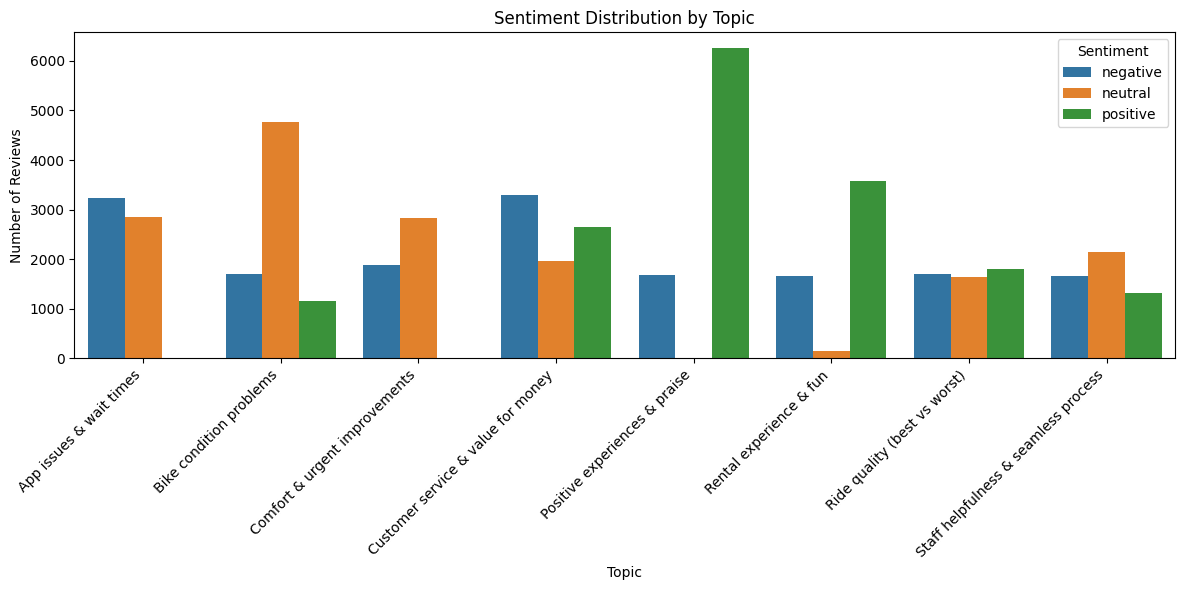

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

topic_dist = lda.transform(X)
df["dominant_topic"] = topic_dist.argmax(axis=1)

df["topic_name"] = df["dominant_topic"].map(topic_names)

sent_topic_counts = df.groupby(["topic_name", "sentiment_label"]).size().reset_index(name="count")

plt.figure(figsize=(12,6))
sns.barplot(
    data=sent_topic_counts,
    x="topic_name", y="count", hue="sentiment_label"
)

plt.xticks(rotation=45, ha="right")
plt.title("Sentiment Distribution by Topic")
plt.ylabel("Number of Reviews")
plt.xlabel("Topic")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()